In [1]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots
sns.set()
import warnings  
warnings.filterwarnings('ignore')
from itertools import product  # some useful functions
import scipy.stats as scs
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from sklearn.model_selection import TimeSeriesSplit  # you have everything done for you 
from sklearn.model_selection import train_test_split
import datetime
from sklearn import metrics

In [2]:
df_G2 = pd.read_csv('G2.csv.xls', sep = ',') 
df_G2['date'] = df_G2['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_G2)
print(df_G2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    156 non-null    datetime64[ns]
 1   SO2op1  156 non-null    float64       
 2   SO2op2  156 non-null    float64       
 3   T       156 non-null    float64       
 4   SO2     156 non-null    float64       
 5   NO2     156 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.4 KB
None


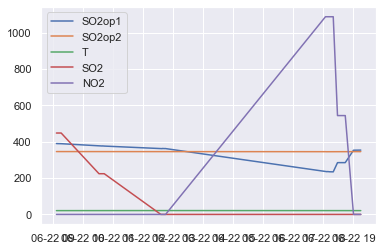

In [3]:
features = list(df_G2.columns)
features.remove('date')

plt.figure('time series')
for coll in features:
    plt.plot(df_G2.date, df_G2[coll], label = str(coll))
plt.legend(loc="best")


$$MLR$$

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


y = df_G2.dropna()['SO2']
X = df_G2.dropna().drop(['SO2'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33)

time_train = X_train.dropna()['date']
X_train = X_train.drop(['date'], axis=1)
time_valid = X_valid.dropna()['date']
X_valid = X_valid.drop(['date'], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid))
list_X = X_train.columns.values.tolist()
X_train_scaled.set_axis(list_X, axis = 'columns', inplace=True)
X_valid_scaled.set_axis(list_X, axis = 'columns', inplace=True)


print(X_train_scaled)



       SO2op1    SO2op2         T       NO2
0    0.907854  1.366007  1.543831 -0.738997
1    1.142137  0.959741 -0.381976 -0.738997
2    0.496177  0.574858 -0.143176 -0.738997
3    1.143237  0.929195 -0.381976 -0.738997
4   -0.754674 -1.096024 -0.863428  0.541931
..        ...       ...       ...       ...
99  -1.631977 -1.563383 -0.381976  1.822859
100 -0.745709 -0.121598 -1.102228  0.541931
101  0.654326  0.764245  2.025283 -0.738997
102  0.653929  0.397689  2.025283 -0.738997
103 -1.650753 -0.979948 -0.381976  1.822859

[104 rows x 4 columns]


In [13]:
def plotCoefficients(model, X_train = X_train, stringg = ""):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")
    plt.title(stringg)
    
def print_metrics(model, X_train = X_train_scaled, X_valid = X_valid_scaled,\
                  y_train = y_train, y_valid = y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print('Scor  \t train \t valid')
    print('MAE  \t', round(metrics.mean_absolute_error(y_train,y_train_pred),1),\
          '\t', round(metrics.mean_absolute_error(y_valid,y_valid_pred),1))
    print('MSE  \t', round(metrics.mean_squared_error(y_train,y_train_pred)),\
          '\t', round(metrics.mean_squared_error(y_valid,y_valid_pred)))
    print('MAPE \t', round(metrics.r2_score(y_train,y_train_pred)*100,2),\
          '\t', round(metrics.r2_score(y_valid,y_valid_pred)*100,2))    

In [28]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
# plotCoefficients(mlr, X_train_scaled, "Coefficients MLR")
print_metrics(mlr)

Scor  	 train 	 valid
MAE  	 27.7 	 27.4
MSE  	 1009 	 953
MAPE 	 96.33 	 95.14


In [29]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2)

lasso = LassoCV(alphas = [ 0.0001, 0.0003, 0.001, 0.003, 0.01,\
                          0.03, 0.1, 0.3, 1, 3,10, 30, 100], cv=ss)
lasso.fit(X_train_scaled, y_train)
# plotCoefficients(lasso, X_train_scaled, "Coefficients Lasso")
print_metrics(lasso)

Scor  	 train 	 valid
MAE  	 28.3 	 27.3
MSE  	 1015 	 944
MAPE 	 96.31 	 95.18


In [30]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [ 0.0001, 0.0003, 0.001, 0.003, 0.01,\
                          0.03, 0.1, 0.3, 1, 3,10, 30, 100], cv=ss)
ridge.fit(X_train_scaled, y_train)
# plotCoefficients(ridge, X_train_scaled, "Coefficients Ridge")
print_metrics(ridge)

Scor  	 train 	 valid
MAE  	 28.5 	 27.3
MSE  	 1031 	 959
MAPE 	 96.25 	 95.11


$$\bf Прогнозирование\ на\ тесте$$

In [31]:
df_test = pd.read_csv('test.csv.xls', sep = ',') 
df_test['date'] = df_test['date'].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
# print(df_test)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    864 non-null    datetime64[ns]
 1   SO2op1  864 non-null    float64       
 2   SO2op2  864 non-null    float64       
 3   T       864 non-null    float64       
 4   NO2     864 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 33.9 KB
None


In [32]:
time_test = df_test.dropna()['date']
X_test = df_test.drop(['date'], axis=1)

X_test_scaled = pd.DataFrame(scaler.transform(X_test))
list_X = X_train.columns.values.tolist()
X_test_scaled.set_axis(list_X, axis = 'columns', inplace=True)

def plot_test_SO2(model, time = time_test, X = X_test_scaled, cl = 'black', st = 'model'):
    plt.plot(time, model.predict(X), color = cl, label = st)



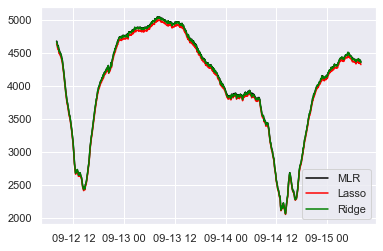

In [33]:
plt.figure("MLR Results")
plot_test_SO2(mlr, cl = 'black', st = 'MLR')
plot_test_SO2(lasso, cl = 'red', st = 'Lasso')
plot_test_SO2(ridge, cl = 'green', st = 'Ridge')
plt.legend(loc="best")


$$\bf MLR\ на\ всём\ G2$$

In [34]:
time = X.dropna()['date']
Xx = X.drop(['date'], axis=1)

X_scaled = pd.DataFrame(scaler.fit_transform(Xx))
X_scaled.set_axis(list_X, axis = 'columns', inplace=True)
print(X_scaled)

mlr_all = LinearRegression()
mlr_all.fit(X_scaled, y)




       SO2op1    SO2op2         T       NO2
0    1.152797  0.468463 -0.675991 -0.765092
1    1.160780  1.262037 -0.448979 -0.765092
2    1.160780  1.262037 -0.675991 -0.765092
3    1.151056  0.865250 -0.448979 -0.765092
4    1.151056  0.865250 -0.448979 -0.765092
..        ...       ...       ...       ...
151  0.522738 -0.739026 -0.221966 -0.765092
152  0.520241  0.534118 -0.221966 -0.765092
153  0.520241  0.534118 -0.448979 -0.765092
154  0.522140  0.782467 -0.221966 -0.765092
155  0.522140  0.782467 -0.221966 -0.765092

[156 rows x 4 columns]


LinearRegression()

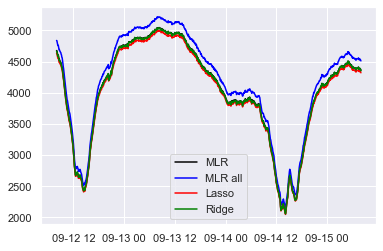

In [35]:
plt.figure("MLR Results")
plot_test_SO2(mlr, cl = 'black', st = 'MLR')
plot_test_SO2(mlr_all, cl = 'blue', st = 'MLR all')
plot_test_SO2(lasso, cl = 'red', st = 'Lasso')
plot_test_SO2(ridge, cl = 'green', st = 'Ridge')
plt.legend(loc="best")

$$\bf Корреляционный\ анализ$$

<AxesSubplot:>

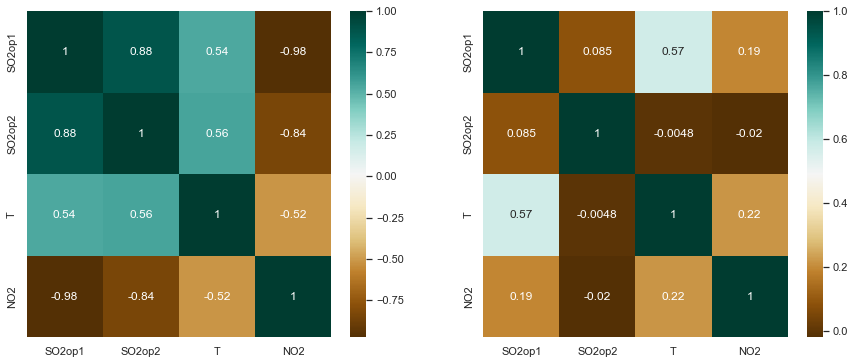

In [44]:
features_test = list(df_test.columns)
features_test.remove('date')

fig = plt.figure()
fig.set_size_inches(15, 6)
ax1 = fig.add_subplot(121)
c_m_pear_G2 = df_G2[features_test].corr(method='pearson')
sns.heatmap(c_m_pear_G2, annot=True, cmap = 'BrBG')

ax2 = fig.add_subplot(122)
c_m_pear_test = df_test[features_test].corr(method='pearson')
sns.heatmap(c_m_pear_test, annot=True, cmap = 'BrBG')


Сравнение корреляционных диаграмм для тренировочного набора данных (G2) и тестового (test):
    
    1) В Полевых испытаниях в отличие от лабораторных 
    практически остутсвует линейная зависимость м/у электродами op1,op2
    2) Влияние T на op1 то же, в отличие от T на op2
    3) NO2 значительно в меньшей степени влияет на показания op1 и op2 в пол.исп
    
Это говорит о необходимости калибровки в полевых испытаниях,

данные собранные в лаборатории отличаются от данных собранных в пол. исп.    

Исходя из корреляционной матрицы для лаборатрных испытаний: 

1) Положительная линейная зависимость между показаниями электродов

2) Отрицательная линейная зависимость между пок. элект. и N02

3) Слабая линнейная зависимость от температуры

4) Слабая положительная зависимость м/у показаниями элект. и SO2